# **DQN with Local Differential Privacy  on Cartpole**
## In this notebook, we propose a local differentially private DQN by disturbing observations i.e. the states seen by the model. We add a gaussian noise to the states before feeding the DQN and filling the replay buffer.

## Acknowledgement

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl/blob/master/dqn_working.ipynb).


## Import

In [ ]:
%matplotlib inline
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.1 MB/s eta 0:00:00


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Initialize environments

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if gym.__version__[:4] == '0.26':
    train_env = gym.make('CartPole-v1')
    test_env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    train_env = gym.make('CartPole-v1', new_step_api=True)
    test_env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

### Seed

In [ ]:
SEED = 42
train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED);

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN algorithm




In [ ]:
n_input = train_env.observation_space.shape[0]
n_hid = 128
n_output = train_env.action_space.n

In [ ]:
print(n_input,n_hid,n_output)

4 128 2


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_input=n_input, n_hid=n_hid, n_output=n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, n_hid)
        self.layer2 = nn.Linear(n_hid, n_hid)
        self.layer3 = nn.Linear(n_hid, n_output)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Action selection

In [ ]:
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# Greedy policy
def LDP_select_action(env, state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():

            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Training

In [ ]:
def LDP_compute_Q_values(memory, policy_net, target_net, batch_size, gamma):

    # If memory too small
    if len(memory) < batch_size:
        return None, None
    
    # Sample batch data
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) # Transpose the batch 

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    Q_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    max_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        max_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # Compute the expected Q values
    expected_Q_values = reward_batch + gamma * max_values

    return Q_values, expected_Q_values

In [ ]:
def LDP_update_policy(memory, policy_net, target_net, batch_size,
                      gamma, criterion, optimizer):

    # Recover Q_values
    Q_values, expected_Q_values = LDP_compute_Q_values(memory, policy_net,
                                                       target_net, batch_size,
                                                       gamma)
    
    # If memory too small, no optimization
    if (Q_values is None) and (expected_Q_values is None):
        return np.inf

    # Compute Huber loss
    loss = criterion(Q_values, expected_Q_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# TAU is the update rate of the target network
TAU = 0.005

# NOISE

MEAN = torch.zeros(4)
STD = torch.tensor([2.4, 0.1, 0.295, 0.1])

def LDP_train(memory, env, policy_net, target_net, batch_size,
              gamma, criterion, optimizer, sigma, level):

    policy_net.train()
    target_net.eval()
    episode_reward = 0
    n_samples = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # add noise for LDP
    if sigma:
        noise = torch.normal(mean=MEAN, std=sigma*STD).to(device)
        state += noise

    for t in count():

        # Select action
        action = LDP_select_action(env, state, policy_net)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        n_samples += 1
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # add noise for LDP
            if sigma:
                noise = torch.normal(mean=MEAN, std=sigma*STD).to(device)
                next_state += noise
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize policy
        loss = LDP_update_policy(memory, policy_net, target_net, batch_size,
                                 gamma, criterion, optimizer)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (policy_net_state_dict[key]*TAU 
                                          + target_net_state_dict[key]*(1-TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    return loss, episode_reward, n_samples

In [ ]:
def LDP_evaluate(env, policy_net):
    global steps_done
    policy_net.eval()
    episode_reward = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = LDP_select_action(env, state, policy_net)
        steps_done -= 1 # do not update steps_done
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            break

    return episode_reward

In [ ]:
batch_size = 128
gamma = 0.99
lr = 1e-4
LOG = 25
N_TRIALS = 25
REWARD_THRESHOLD = 475

MAX_EPISODES = 1000

# DP
level = 1e-2
noise_levels = [0, 0.05, 0.1, 0.25, 0.5] 
train_rewards = np.zeros((len(noise_levels), MAX_EPISODES))
test_rewards = np.zeros((len(noise_levels), MAX_EPISODES))

for i, sigma in enumerate(noise_levels):
    train_env.reset(seed=SEED);
    test_env.reset(seed=SEED+1);
    
    print("-------------- Noise: sigma = {} ---------------\n".format(sigma))

    # Models
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    # Optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

    # Criterion
    criterion = nn.SmoothL1Loss()

    # Memory Buffer
    memory = ReplayMemory(10000)
    steps_done = 0  
    convergence = False
    
    for episode in range(MAX_EPISODES):

        if not convergence:
            # Train model
            loss, train_reward, n_samples = LDP_train(memory, train_env, policy_net,
                                                      target_net, batch_size, gamma,
                                                      criterion, optimizer, sigma, level)
            # Evaluate model
            test_reward = LDP_evaluate(test_env, policy_net)

            # Update rewards
            train_rewards[i][episode] = train_reward
            test_rewards[i][episode] = test_reward
            
            mean_train_rewards = np.mean(train_rewards[i][episode-N_TRIALS:episode+1])
            mean_test_rewards = np.mean(test_rewards[i][episode-N_TRIALS:episode+1])
            
            convergence = (mean_test_rewards) >= 475
            if convergence:
                print("Achieved convergence")
        else:
            train_rewards[i][episode] = train_rewards[i][episode-1]
            test_rewards[i][episode] = test_rewards[i][episode-1]
        
        if episode % LOG == 0:
            print(f'| Episode: {episode:3} | Train Reward: {train_reward:5.1f} | Test Reward: {test_reward:5.1f} |')


-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  11.0 | Test Reward:  23.0 |


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


| Episode:  25 | Train Reward:  12.0 | Test Reward:  24.0 |
| Episode:  50 | Train Reward:  11.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  10.0 | Test Reward:   9.0 |
| Episode: 125 | Train Reward:  13.0 | Test Reward:  11.0 |
| Episode: 150 | Train Reward:  96.0 | Test Reward: 108.0 |
| Episode: 175 | Train Reward: 148.0 | Test Reward: 128.0 |
| Episode: 200 | Train Reward: 115.0 | Test Reward: 153.0 |
| Episode: 225 | Train Reward: 136.0 | Test Reward: 125.0 |
| Episode: 250 | Train Reward: 203.0 | Test Reward: 195.0 |
| Episode: 275 | Train Reward: 157.0 | Test Reward: 222.0 |
| Episode: 300 | Train Reward: 296.0 | Test Reward: 154.0 |
| Episode: 325 | Train Reward: 102.0 | Test Reward: 157.0 |
| Episode: 350 | Train Reward: 103.0 | Test Reward:  75.0 |
| Episode: 375 | Train Reward: 123.0 | Test Reward: 185.0 |
| Episode: 400 | Train Reward: 314.0 | Test Reward: 394.0 |
| Episode: 425 | Train Reward: 500.0 | T

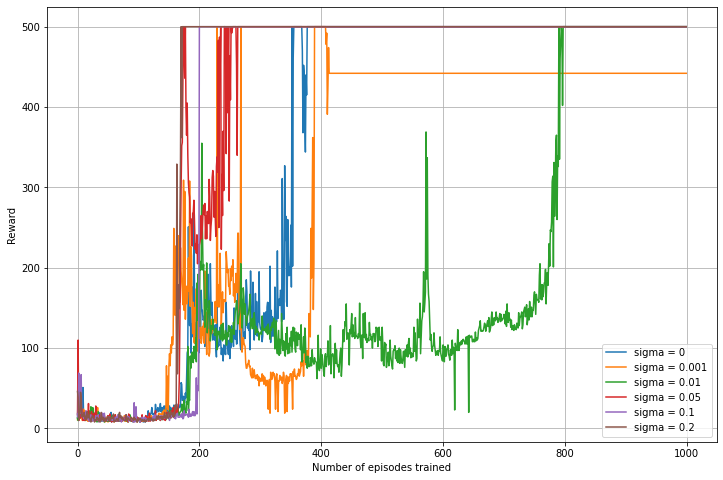

In [ ]:
fig = plt.figure(figsize=(12,8))

for i, sigma in enumerate(noise_levels):
    plt.plot(test_rewards[i], label='sigma = {}'.format(sigma))

plt.xlabel('Number of episodes trained')
plt.ylabel('Reward')

plt.legend()
plt.legend(loc='lower right')
plt.grid()
plt.show()